# FASE 1: RECOLECCION Y PREPARACION DE DATOS

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import load_model
import copy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
import pickle
import seaborn as sns
from scipy import stats
from sklearn import set_config  

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json

In [2]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def guardarModelo(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle guardado")
        
#Funciones para guardar y cargar la Red Neuronal (Arquitectura y Pesos)
def guardarRNN(model,nombreArchivo):
    print("Guardando Red Neuronal en Archivo")  
    model.save(nombreArchivo+'.h5')
    print("Red Neuronal Grabada en Archivo")   
    
def cargarRNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')    
    print("Red Neuronal Cargada desde Archivo") 
    return model

def transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features):
    dataframeTransformado=copy.deepcopy(dataframe)
    cantidadTotalVariables = len(dataframeTransformado.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadVariablesBinarias=cantidadVariablesBinarias+dataframeTransformado[variable].nunique()
    print('Cantidad de variables binarias: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    print('Cantidad de variables que habrá después de transformación de variables: ',cantidadTotalVariablesConTransformacion)
    #Definición de transformadores (preprocesadores)
    #1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
    categorical_ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())])
    categorical_nominal_transformer_ConNombres = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
    preprocesorCategoricoNumericoConNombres = ColumnTransformer(
        transformers=[
            ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
            ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
        ],remainder='passthrough',n_jobs=-1)
    #2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(0, 1)))])
    preprocesorMinMax = ColumnTransformer(transformers =[
        ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
    standardscaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True,with_std=True))])
    preprocesorStandardScaler = ColumnTransformer(transformers =[
        ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #Construcción de Pipeline con transformadores
    pipe = Pipeline(steps=[
        ('prepcn', preprocesorCategoricoNumericoConNombres) 
        #('prepstandard', preprocesorStandardScaler)
        #('prepminmax', preprocesorMinMax)
    ])
    #Transformación de variables
    X_Transformado = pipe.fit_transform(dataframeTransformado)
    print('********** Pipeline aplicado')
    guardarPipeline(pipe,'pipePreprocesadores')
    set_config(display='diagram')
    #Formación de dataframe transformado
    cnamesDataset1=[]
    if len(categorical_ordinal_features)!=0:
        cnamesDataset1.extend(categorical_ordinal_features)
    if len(categorical_nominal_features)!=0:
        cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
        cnamesDataset1.extend(cnamesDataset2)
    cnamesDataset3 = numeric_features
    cnamesDataset1.extend(cnamesDataset3)
    print(cnamesDataset1)
    dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
    #dataframeTransformado = pd.concat([dataframeTransformado, salida], axis = 1)
    return dataframeTransformado, pipe

In [20]:
# Cargar los datos
data = pd.read_csv("Hepatitis.data")

In [21]:
#Cambiar las cabeceras del dataframe
data.rename(columns={
    '2': 'Class',
    '30': 'AGE',
    '2.1': 'SEX',
    '1': 'STEROID',
    '2.2': 'ANTIVIRALS',
    '2.3': 'FATIGUE',
    '2.4': 'MALAISE',
    '2.5': 'ANOREXIA',
    '1.1': 'LIVER_BIG',
    '2.6': 'LIVER_FIRM',
    '2.7': 'SPLEEN_PALPABLE',
    '2.8': 'SPIDERS',
    '2.9': 'ASCITES',
    '2.10': 'VARICES',
    '1.00': 'BILIRUBIN',
    '85': 'ALK_PHOSPHATE',
    '18': 'SGOT',
    '4.0': 'ALBUMIN',
    '?': 'PROTIME',
    '1.2': 'HISTOLOGY'
}, inplace=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Class            154 non-null    int64 
 1   AGE              154 non-null    int64 
 2   SEX              154 non-null    int64 
 3   STEROID          154 non-null    object
 4   ANTIVIRALS       154 non-null    int64 
 5   FATIGUE          154 non-null    object
 6   MALAISE          154 non-null    object
 7   ANOREXIA         154 non-null    object
 8   LIVER_BIG        154 non-null    object
 9   LIVER_FIRM       154 non-null    object
 10  SPLEEN_PALPABLE  154 non-null    object
 11  SPIDERS          154 non-null    object
 12  ASCITES          154 non-null    object
 13  VARICES          154 non-null    object
 14  BILIRUBIN        154 non-null    object
 15  ALK_PHOSPHATE    154 non-null    object
 16  SGOT             154 non-null    object
 17  ALBUMIN          154 non-null    ob

In [23]:
# Se presentan errores de integridad por los signos ?, por lo que se reemplaza por '1' para no tener inconsistencia en el 
# entrenamiento
data=data.replace(to_replace='?',value='Nan')

In [24]:
data

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,Nan,1
1,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,Nan,1
2,2,31,1,Nan,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
3,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,Nan,200,4.0,Nan,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.90,95,28,4.0,75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1,46,1,2,2,1,1,1,2,2,2,1,1,1,7.60,Nan,242,3.3,50,2
150,2,44,1,2,2,1,2,2,2,1,2,2,2,2,0.90,126,142,4.3,Nan,2
151,2,61,1,1,2,1,1,2,1,1,2,1,2,2,0.80,75,20,4.1,Nan,2
152,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


In [25]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Class            154 non-null    int64 
 1   AGE              154 non-null    int64 
 2   SEX              154 non-null    int64 
 3   STEROID          154 non-null    object
 4   ANTIVIRALS       154 non-null    int64 
 5   FATIGUE          154 non-null    object
 6   MALAISE          154 non-null    object
 7   ANOREXIA         154 non-null    object
 8   LIVER_BIG        154 non-null    object
 9   LIVER_FIRM       154 non-null    object
 10  SPLEEN_PALPABLE  154 non-null    object
 11  SPIDERS          154 non-null    object
 12  ASCITES          154 non-null    object
 13  VARICES          154 non-null    object
 14  BILIRUBIN        154 non-null    object
 15  ALK_PHOSPHATE    154 non-null    object
 16  SGOT             154 non-null    object
 17  ALBUMIN          154 non-null    ob

In [26]:
df = data[['AGE', 'SEX', 'ANTIVIRALS','STEROID','FATIGUE','MALAISE','BILIRUBIN', 'ALBUMIN', 'ANOREXIA', 'LIVER_BIG','SGOT', 'Class']]
df = df.dropna(subset=['AGE', 'SEX', 'ANTIVIRALS','STEROID','FATIGUE','MALAISE','BILIRUBIN', 'ALBUMIN', 'ANOREXIA', 'LIVER_BIG','SGOT', 'Class'])
print(df.shape)

(154, 12)


In [27]:
#Selección de variables y separamos Y
dataframe=copy.deepcopy(df)

#Xsubset.fillna(0)
#Se separa variable independiente:
Y = dataframe.Class.values
dataframe=dataframe.drop(['Class'], axis=1)

In [28]:
print(dataframe.dtypes)

AGE            int64
SEX            int64
ANTIVIRALS     int64
STEROID       object
FATIGUE       object
MALAISE       object
BILIRUBIN     object
ALBUMIN       object
ANOREXIA      object
LIVER_BIG     object
SGOT          object
dtype: object


In [30]:
dataframePreprocesado=copy.deepcopy(dataframe)
categorical_ordinal_features = []
categorical_nominal_features = ['STEROID','FATIGUE','MALAISE','BILIRUBIN', 'ALBUMIN', 'ANOREXIA', 'LIVER_BIG','SGOT'] 
numeric_features = ['AGE','SEX','ANTIVIRALS']
salida = Y

In [31]:
dataframeTransformado, pipe=transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features)
dataframeTransformado.to_csv("DatasetT.csv", sep=";",index = False)
guardarPipeline(pipe,'PipeGenerate')
dataframeTransformado.head()

Cantidad de variables antes de transformación de variables:  11
Cantidad de variables binarias:  165
Cantidad de variables que habrá después de transformación de variables:  168
********** Pipeline aplicado
['STEROID_1', 'STEROID_2', 'STEROID_Nan', 'FATIGUE_1', 'FATIGUE_2', 'FATIGUE_Nan', 'MALAISE_1', 'MALAISE_2', 'MALAISE_Nan', 'BILIRUBIN_0.30', 'BILIRUBIN_0.40', 'BILIRUBIN_0.50', 'BILIRUBIN_0.60', 'BILIRUBIN_0.70', 'BILIRUBIN_0.80', 'BILIRUBIN_0.90', 'BILIRUBIN_1.00', 'BILIRUBIN_1.10', 'BILIRUBIN_1.20', 'BILIRUBIN_1.30', 'BILIRUBIN_1.40', 'BILIRUBIN_1.50', 'BILIRUBIN_1.60', 'BILIRUBIN_1.70', 'BILIRUBIN_1.80', 'BILIRUBIN_1.90', 'BILIRUBIN_2.00', 'BILIRUBIN_2.20', 'BILIRUBIN_2.30', 'BILIRUBIN_2.40', 'BILIRUBIN_2.50', 'BILIRUBIN_2.80', 'BILIRUBIN_2.90', 'BILIRUBIN_3.00', 'BILIRUBIN_3.20', 'BILIRUBIN_3.50', 'BILIRUBIN_3.90', 'BILIRUBIN_4.10', 'BILIRUBIN_4.20', 'BILIRUBIN_4.60', 'BILIRUBIN_4.80', 'BILIRUBIN_7.60', 'BILIRUBIN_8.00', 'BILIRUBIN_Nan', 'ALBUMIN_2.1', 'ALBUMIN_2.2', 'ALBUMIN_2

,STEROID_1,STEROID_2,STEROID_Nan,FATIGUE_1,FATIGUE_2,FATIGUE_Nan,MALAISE_1,MALAISE_2,MALAISE_Nan,BILIRUBIN_0.30,...,SGOT_81,SGOT_86,SGOT_89,SGOT_90,SGOT_92,SGOT_98,SGOT_Nan,AGE,SEX,ANTIVIRALS
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,2.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,1.0,2.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,2.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,2.0


In [33]:
dataframeTransformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Columns: 168 entries, STEROID_1 to ANTIVIRALS
dtypes: float64(168)
memory usage: 202.2 KB


# FASE 2: APRENDIZAJE 

In [34]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(dataframeTransformado, Y, test_size=0.2, random_state=42)
X_train.shape[1]

168

<AxesSubplot:ylabel='count'>

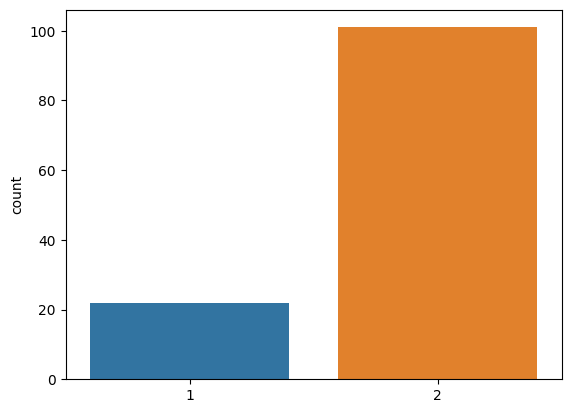

In [35]:
sns.countplot(x=y_train)

In [37]:
# Normalizar los datos de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Construir la arquitectura de la red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(168,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=30, batch_size=8)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/30
16/16 [==============================] - 2s 8ms/step - loss: -8.0369 - acc: 0.1545
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: -60.6564 - acc: 0.1789
Epoch 3/30
16/16 [==============================] - 0s 5ms/step - loss: -204.2200 - acc: 0.1789
Epoch 4/30
16/16 [==============================] - 0s 6ms/step - loss: -478.5898 - acc: 0.1789
Epoch 5/30
16/16 [==============================] - 0s 6ms/step - loss: -941.1546 - acc: 0.1789
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: -1643.3882 - acc: 0.1789
Epoch 7/30
16/16 [==============================] - 0s 6ms/step - loss: -2609.5547 - acc: 0.1789
Epoch 8/30
16/16 [==============================] - 0s 6ms/step - loss: -3943.0273 - acc: 0.1789
Epoch 9/30
16/16 [==============================] - 0s 5ms/step - loss: -5674.2969 - acc: 0.1789
Epoch 10/30
16/16 [==============================] - 0s 5ms/step - loss: -7854.8013 - acc: 0.1789
Epoch 11/30
16/16 [==================

In [38]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Resultado en Train:')
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

#Fase de Testing
score = model.evaluate(X_test, y_test, verbose=0)
print('Resultado en Test:')
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

#mostrar pesos de la red
#print(model.get_weights())
#Guardar pesos y la arquitectura de la red en un archivo 

nombreArchivoModelo='arquitectura_prueba'
guardarRNN(model,nombreArchivoModelo)

#Cargar pesos y la arquitectura
model2=cargarRNN(nombreArchivoModelo) 

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc']) #ADADELTA: An Adaptive Learning Rate Method
score = model2.evaluate(X_train, y_train, verbose=0)
print('Resultado en Train:')
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

#Fase de Testing
print('Resultado en Test:')
score = model2.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model2.metrics_names[1], score[1]*100))

Resultado en Train:
acc: 17.89%
Resultado en Test:
acc: 32.26%
Guardando Red Neuronal en Archivo
Red Neuronal Grabada en Archivo
Red Neuronal Cargada desde Archivo
Resultado en Train:
acc: 17.89%
Resultado en Test:
acc: 32.26%


In [39]:
#Predicciones
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
#y_pred = transformarPrediccion(y_pred)
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

1/1 [==============================] - 0s 260ms/step


,real,predicción
0,2,1.0
1,2,1.0
2,2,1.0
3,1,1.0
4,2,1.0
5,2,1.0
6,2,1.0
7,2,1.0
8,2,1.0
9,2,1.0


In [41]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)


Mean Absolute Error (MAE): 0.6774
Mean Squared Error (MSE): 0.6774
Root Mean Squared Error (RMSE): 0.8231
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1: 1.0


# Prediccion: aplicacion de un nuevo sample

In [48]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

def cargarNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')
    print("Red Neuronal Cargada desde Archivo") 
    return model

In [50]:
#Predicciones con nuevos datos

#La siguiente función tomará los datos de entrada, los va a integrar a una dataframe, los va a preprocesar, y 
#retornará una predicción con la salida "0" o "1", es decir, "sobrevivió" o "no sobrevivió"
def prediccionSobrevivencia(Age=34, Sex=1, Antivirals=1 ,Steroid ='2',Fatigue='2', Malaise='2', Bilirubine='6.5', Albumin='', Anorexia='2.9', Liver='1', Sgot='50'):
    cnames = ['AGE', 'SEX', 'ANTIVIRALS','STEROID','FATIGUE','MALAISE','BILIRUBIN', 'ALBUMIN', 'ANOREXIA', 'LIVER_BIG','SGOT']
    data = [[Age, Sex, Antivirals,Steroid,Fatigue, Malaise, Bilirubine, Albumin, Anorexia, Liver, Sgot]]
    my_X = pd.DataFrame(data=data, columns=cnames)
    print(my_X)
    
    transformador=cargarPipeline('PipeGenerate')
    my_X = transformador.transform(my_X)
    print(my_X)
    
    modeloRN=cargarNN('arquitectura_prueba')
    
    pred = modeloRN.predict(my_X)
    print(pred)
    return pred

#print('Predicción:',prediccionSobrevivencia())
print('Predicción:',prediccionSobrevivencia(Age=70, Sex=2, Antivirals=1 ,Steroid ='1',Fatigue='1', Malaise='1', Bilirubine='6.5', Albumin='', Anorexia='2.9', Liver='2', Sgot='50'))

   AGE  SEX  ANTIVIRALS STEROID FATIGUE MALAISE BILIRUBIN ALBUMIN ANOREXIA  \
0   70    2           1       1       1       1       6.5              2.9   

  LIVER_BIG SGOT  
0         2   50  
[[1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 70 2 1]]
Red Neuronal Cargada desde Archivo
1/1 [==============================] - 0s 177ms/step
[[1]]
Predicción: [[1]]
